In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
#df = df.sample(frac=1, random_state=100)
#df.head()

In [4]:
df. shape

(1048567, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [6]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

The columns with NA values account for less than 1% of our data, so I'm just going to drop them. I don't understand why CustAccountBalance would have unknown values, the only thought I have is that they have no account, or a total balance of 0, so if I kept them, I would probaby just fill with 0 instead of a median value. CustGender could matter, that's something I'd have to explore before considering if I would want to nn impute this, and the location could matter as well, with the same deal. However, we have enough data to ignore doing this.

In [7]:
df = df.dropna()
df['CustomerDOB'].value_counts()

1/1/1800    56292
1/1/89        809
1/1/90        784
6/8/91        698
1/1/91        665
            ...  
2/12/51         1
20/3/52         1
26/9/47         1
4/10/41         1
24/10/44        1
Name: CustomerDOB, Length: 17233, dtype: int64

There are a lot of birthdates on January 1st, which seems  alittle suspicious. There's also a lot of customers birth DOB on 1/1/1800, having 70x the number as the next highest date. This is probably some default the bank has where this information is unknown, althought that is a little suspicous. I'll remove them.

In [8]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]
df['CustomerDOB'].value_counts()

1/1/89      809
1/1/90      784
6/8/91      698
1/1/91      665
1/1/92      631
           ... 
23/2/05       1
28/11/42      1
23/9/49       1
14/3/40       1
24/10/44      1
Name: CustomerDOB, Length: 17232, dtype: int64

In [9]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format = '%d/%m/%y')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [10]:
df.loc[df['CustomerDOB'].dt.year >= 2021, ['CustomerDOB']] -= pd.DateOffset(years = 100)
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [11]:
df['TransactionDate'].value_counts()

7/8/16      26022
13/8/16     25478
4/9/16      25392
6/8/16      25267
3/9/16      25102
10/9/16     24424
11/9/16     24308
14/8/16     24262
15/8/16     23001
21/8/16     21655
2/9/16      21541
12/8/16     21115
1/9/16      21019
9/8/16      20489
11/8/16     20461
8/9/16      20447
10/8/16     20352
9/9/16      20308
27/8/16     20130
20/8/16     20031
5/9/16      20024
7/9/16      19904
5/8/16      19890
28/8/16     19874
17/8/16     19763
8/8/16      19647
2/8/16      19631
4/8/16      19428
13/9/16     19391
12/9/16     19385
3/8/16      19274
1/8/16      19213
16/8/16     19065
14/9/16     18573
15/9/16     18482
6/9/16      18440
31/8/16     18368
18/8/16     18302
19/8/16     17394
22/8/16     17339
25/8/16     17335
24/8/16     16647
26/8/16     16463
30/8/16     16119
23/8/16     16056
29/8/16     15534
18/9/16     13902
26/9/16     11541
25/9/16      7766
27/9/16      6910
22/9/16      6350
21/10/16     3408
23/9/16      3276
30/9/16      1822
16/10/16        2
Name: Tran

All the trnasactions took place in a roughly two month period from August to October, this could account for the low transaction frequency

In [12]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format = '%d/%m/%y')

Text(0.5, 1.0, 'Number of transactions in each month')

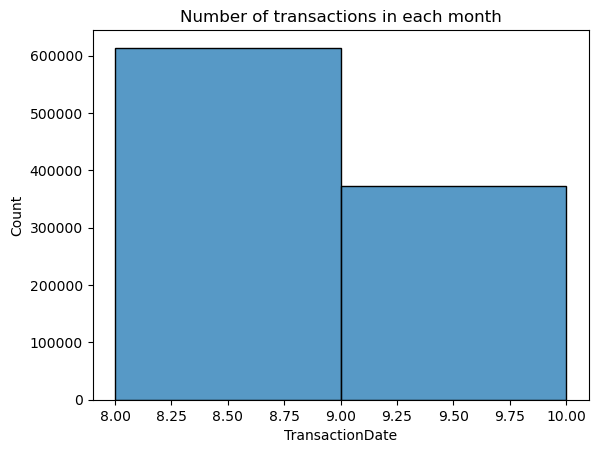

In [13]:
sns.histplot(x = df['TransactionDate'].dt.month, bins = 3, binwidth = 1)
plt.title('Number of transactions in each month')

In [14]:
df['Age'] = (pd.to_datetime('today') - df['CustomerDOB'])/np.timedelta64(1, 'Y')
df['DaysSinceTransaction'] = (pd.to_datetime('today') - df['TransactionDate'])/np.timedelta64(1, 'D')
df['DaysSinceTransaction'] = df['DaysSinceTransaction'] - df['DaysSinceTransaction'].min()
temp = df[['CustomerID', 'TransactionID']].groupby(by = 'CustomerID', as_index = False, sort = True).count().reset_index()
df = df.sample(frac=1, random_state=100)

In [15]:
df = df[:50000]

In [16]:
df.shape

(50000, 11)

In [17]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,DaysSinceTransaction
587399,T587400,C4323244,1976-03-17,M,VADODARA,82511.08,2016-08-23,152146,2624.0,46.745515,59.0
718697,T718698,C5912324,1986-11-12,F,NAVI MUMBAI,18640.00,2016-09-03,213459,672.0,36.089580,48.0
698210,T698211,C1440027,1990-10-20,M,GADCHIROLI,1352.29,2016-08-30,204501,24.0,32.152470,52.0
1009061,T1009062,C5792952,1994-08-14,M,PUNE,668.41,2016-09-13,234516,110.0,28.335828,38.0
365732,T365733,C1526033,1989-08-21,M,DOHA,51732.07,2016-08-14,192203,1900.0,33.316081,68.0


In [18]:
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionID' : 'TransactionFrequency'})
df = df.merge(right = temp, on = 'CustomerID')
df.head()

,TransactionID_x,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,DaysSinceTransaction,TransactionID_y
0,T587400,C4323244,1976-03-17,M,VADODARA,82511.08,2016-08-23,152146,2624.0,46.745515,59.0,2
1,T718698,C5912324,1986-11-12,F,NAVI MUMBAI,18640.00,2016-09-03,213459,672.0,36.089580,48.0,1
2,T698211,C1440027,1990-10-20,M,GADCHIROLI,1352.29,2016-08-30,204501,24.0,32.152470,52.0,1
3,T1009062,C5792952,1994-08-14,M,PUNE,668.41,2016-09-13,234516,110.0,28.335828,38.0,1
4,T365733,C1526033,1989-08-21,M,DOHA,51732.07,2016-08-14,192203,1900.0,33.316081,68.0,1


In [19]:
df = df.rename(columns = {'TransactionID_y' : 'TransactionFrequency',
                         'DaysSinceTransaction' : 'Recency'})

In [20]:
df.shape

(50000, 12)

In [21]:
rmf = df.drop(columns = ['CustGender', 'CustLocation', 'CustLocation',
                         'CustAccountBalance', 'TransactionTime', 'Age']
             ).groupby(by = 'CustomerID').agg({'Recency' : 'min',
                                               'TransactionFrequency': 'first',
                                               'TransactionAmount (INR)' : 'mean'})
df = df.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
rmf = rmf.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
rmf.head()

,Recency,TransactionFrequency,AverageTransactionAmount
CustomerID,,,
C1010035,55.0,2,700.0
C1010075,36.0,1,350.0
C1010238,77.0,1,4615.0
C1010273,72.0,1,1040.0
C1010322,77.0,1,2350.0


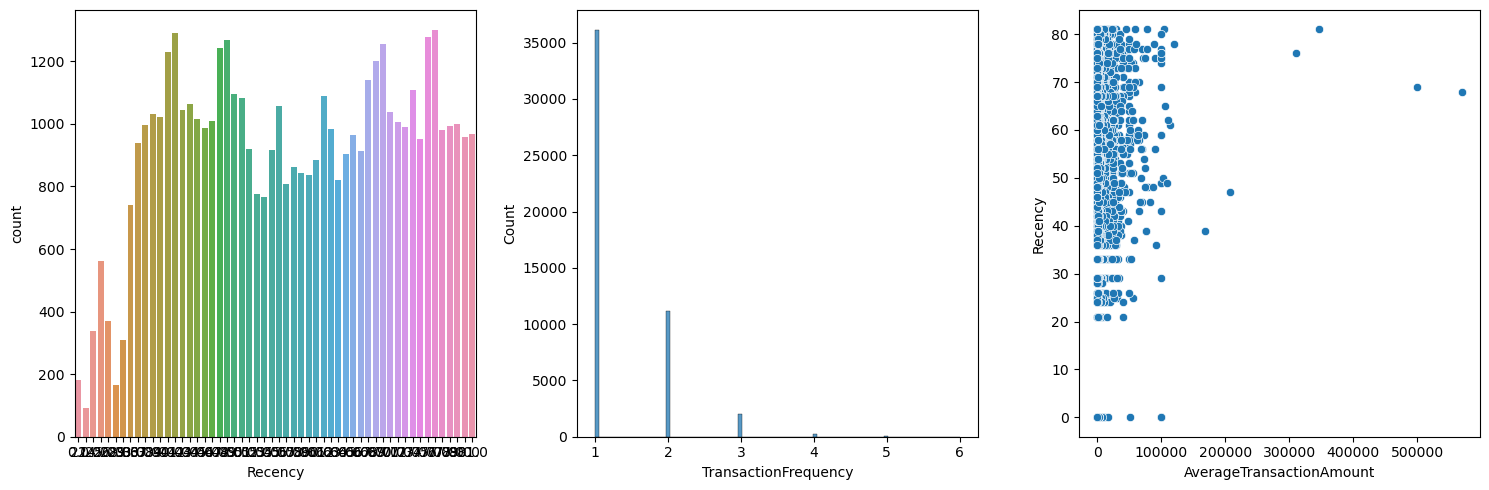

In [22]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes = axes.flatten()

sns.countplot(x = 'Recency', data = rmf, ax = axes[0])
sns.histplot(x = 'TransactionFrequency', data = rmf, ax = axes[1])
sns.scatterplot(x = 'AverageTransactionAmount', y = 'Recency', data = rmf, ax = axes[2])
plt.tight_layout()

In [23]:
def recency_score(value, quartiles):
    if value < quartiles[0.25]:
        return 4
    if value < quartiles[0.5]:
        return 3
    if value < quartiles[.75]:
        return 2
    else:
        return 1

def monetary_score(value, quartiles):
    if value < quartiles[0.25]:
        return 1
    if value < quartiles[0.5]:
        return 2
    if value < quartiles[0.75]:
        return 3
    else:
        return 4
    
quartiles = rmf.quantile([0.25, 0.5, 0.75]).to_dict()

rmf['recency_score'] = rmf['Recency'].apply(recency_score, quartiles = quartiles['Recency'],)
rmf['frequency_score'] = rmf['TransactionFrequency'].astype(int)
rmf.loc[rmf['frequency_score'] > 4, 'frequency_score'] = 4
rmf['monetary_score'] = rmf['AverageTransactionAmount'].apply(monetary_score, quartiles = quartiles['AverageTransactionAmount'],)
rmf['total_score'] = rmf['recency_score'] + rmf['frequency_score'] + rmf['monetary_score']

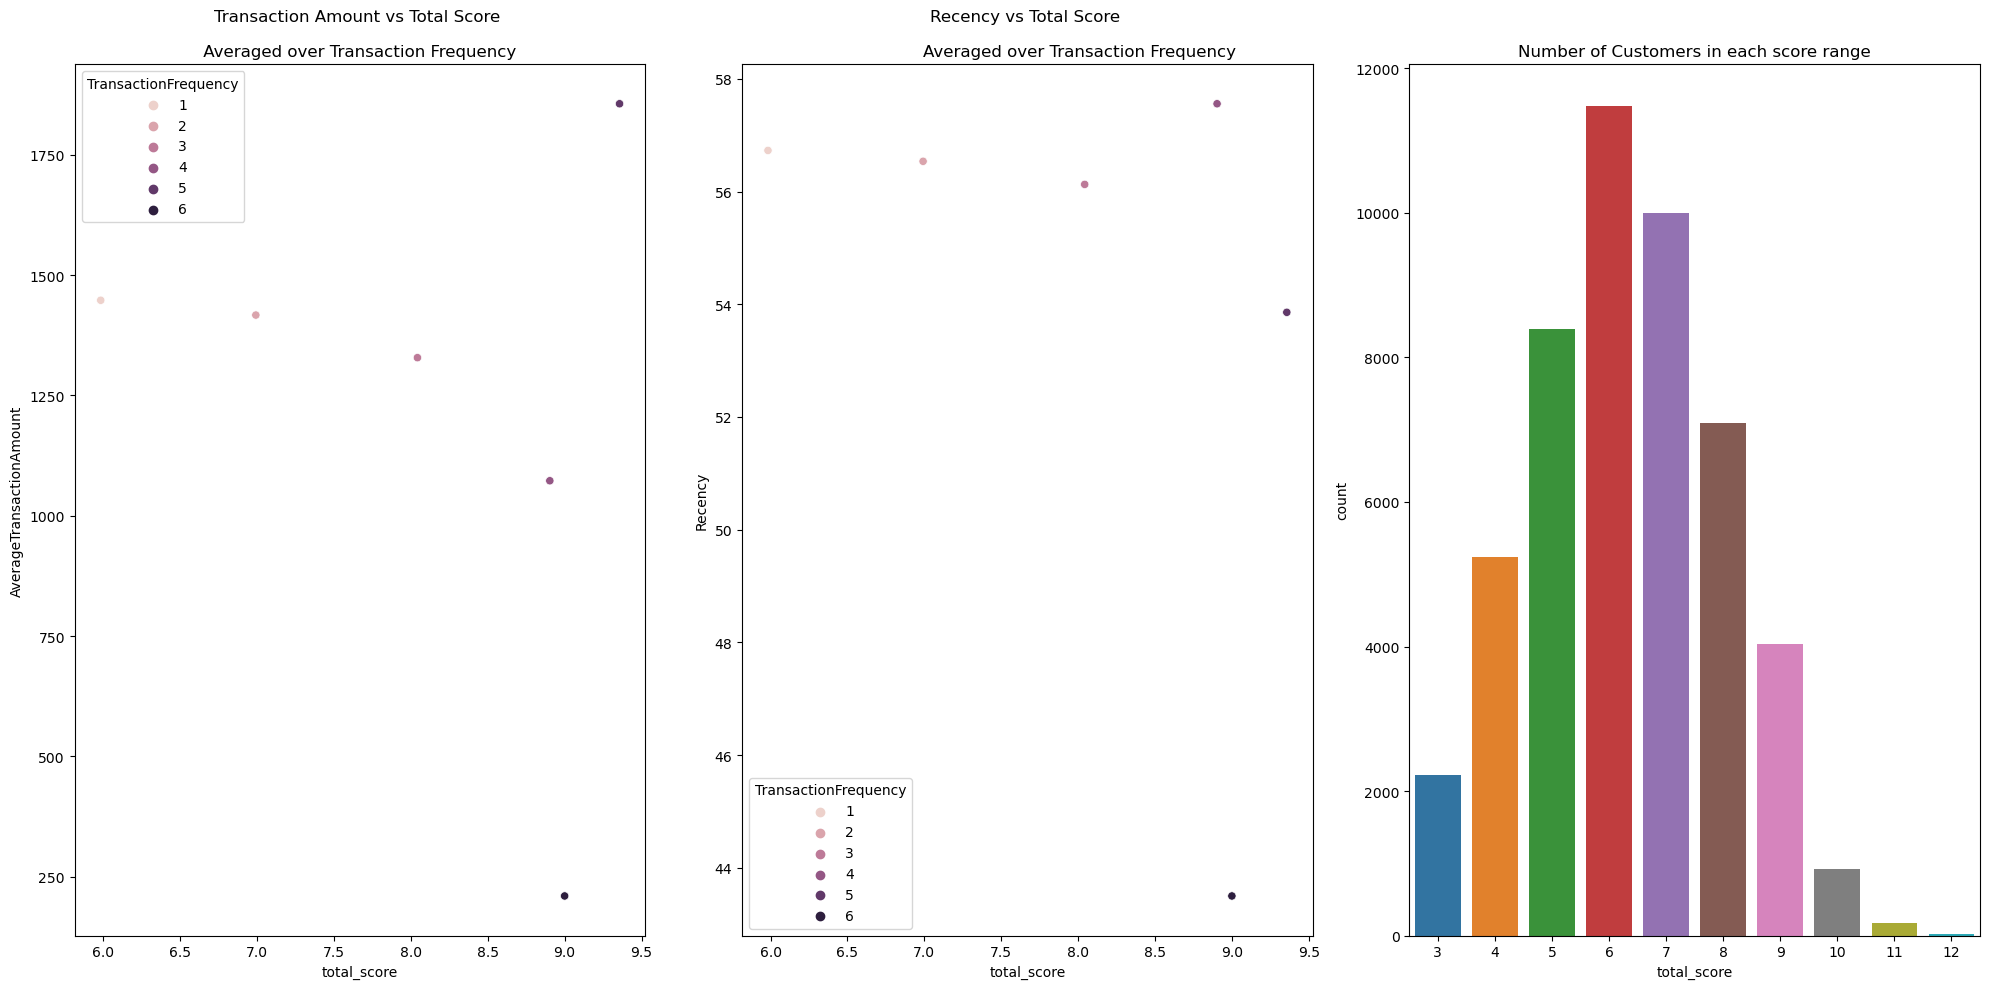

In [24]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
axes = axes.flatten()

recency = rmf.groupby(by = 'TransactionFrequency').mean().reset_index()
avg_amount = rmf.groupby(by = 'TransactionFrequency').mean().reset_index()


sns.scatterplot(x = 'total_score', y = 'AverageTransactionAmount', hue = 'TransactionFrequency',
            data = avg_amount, ax = axes[0])
axes[0].set_title('''Transaction Amount vs Total Score 
                  \n Averaged over Transaction Frequency ''')
sns.scatterplot(x = 'total_score', y = 'Recency', data = recency, hue = 'TransactionFrequency',
            ax = axes[1])
axes[1].set_title('''Recency vs Total Score \n
                    Averaged over Transaction Frequency''')
sns.countplot(x = 'total_score', data = rmf, ax = axes[2])
axes[2].set_title('Number of Customers in each score range')
plt.tight_layout()

In [25]:
rmf[rmf.total_score == 12].count()

Recency                     19
TransactionFrequency        19
AverageTransactionAmount    19
recency_score               19
frequency_score             19
monetary_score              19
total_score                 19
dtype: int64

The average transaction is mostly constant for the transaction frequency range, except for the sharp increase in the range of 4 - 5 transactions over the three months, and a sudden sharp decrease for the most frequent (and significantly rarer) 6 transactions over that interval. Since 4 - 6 transactions all give a frequency score of 4, one would expect that they share the same average total score, however this is clearly not the case, with the average total score increasing from 4-6 transactions.

When we look at the recency, we see that the average recency decreases with the average frequency (which shouldn't be shocking), which will compensate for the reduced average transactional amount.

In [26]:
rmf.groupby(by = 'total_score').describe().T

total_score                              3            4            5   \
Recency                  count  2221.000000  5237.000000  8394.000000   
                         mean     75.438991    70.008211    64.419347   
                         std       3.440026     7.093540    10.493925   
                         min      70.000000    57.000000    45.000000   
                         25%      73.000000    64.000000    56.000000   
                         50%      75.000000    71.000000    65.000000   
                         75%      78.000000    76.000000    74.000000   
                         max      81.000000    81.000000    81.000000   
TransactionFrequency     count  2221.000000  5237.000000  8394.000000   
                         mean      1.000000     1.128318     1.199309   
                         std       0.000000     0.334475     0.433819   
                         min       1.000000     1.000000     1.000000   
                         25%       1.000000     1.000000     1.000000   
                         50%       1.000000     1.000000     1.000000   
                         75%       1.000000     1.000000     1.000000   
                         max       1.000000     2.000000     3.000000   
AverageTransactionAmount count  2221.000000  5237.000000  8394.000000   
                         mean     70.779172   157.082704   321.960418   
                         std      42.481836   116.757837   284.580479   
                         min       0.000000     0.000000     0.000000   
                         25%      33.000000    50.000000   100.000000   
                         50%      61.000000   125.000000   240.000000   
                         75%     100.000000   248.000000   496.750000   
                         max     151.340000   431.150000  1127.000000   
recency_score            count  2221.000000  5237.000000  8394.000000   
                         mean      1.000000     1.438419     1.883846   
                         std       0.000000     0.496241     0.792836   
                         min       1.000000     1.000000     1.000000   
                         25%       1.000000     1.000000     1.000000   
                         50%       1.000000     1.000000     2.000000   
                         75%       1.000000     2.000000     3.000000   
                         max       1.000000     2.000000     3.000000   
frequency_score          count  2221.000000  5237.000000  8394.000000   
                         mean      1.000000     1.128318     1.199309   
                         std       0.000000     0.334475     0.433819   
                         min       1.000000     1.000000     1.000000   
                         25%       1.000000     1.000000     1.000000   
                         50%       1.000000     1.000000     1.000000   
                         75%       1.000000     1.000000     1.000000   
                         max       1.000000     2.000000     3.000000   
monetary_score           count  2221.000000  5237.000000  8394.000000   
                         mean      1.000000     1.433263     1.916845   
                         std       0.000000     0.495574     0.799288   
                         min       1.000000     1.000000     1.000000   
                         25%       1.000000     1.000000     1.000000   
                         50%       1.000000     1.000000     2.000000   
                         75%       1.000000     2.000000     3.000000   
                         max       1.000000     2.000000     3.000000   

total_score                                6              7              8   \
Recency                  count   11484.000000   10005.000000    7097.000000   
                         mean       58.182341      52.712544      46.528110   
                         std        14.853959      13.596712      11.330366   
                         min         0.000000       0.000000       0.000000   
                         25

Unsurpisingly, due to the low frequency of transactions, most people fall around a total score of the 5 - 7  out of 12. There are similar numbers of 3, 4 to 8, 9, and very few 10 and above. About 1% of the people have a score above 10. Moving on to clustering:

In [27]:
df.head(10)

,TransactionID_x,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,AverageTransactionAmount,Age,Recency,TransactionFrequency
0,T587400,C4323244,1976-03-17,M,VADODARA,82511.08,2016-08-23,152146,2624.00,46.745515,59.0,2
1,T718698,C5912324,1986-11-12,F,NAVI MUMBAI,18640.00,2016-09-03,213459,672.00,36.089580,48.0,1
2,T698211,C1440027,1990-10-20,M,GADCHIROLI,1352.29,2016-08-30,204501,24.00,32.152470,52.0,1
3,T1009062,C5792952,1994-08-14,M,PUNE,668.41,2016-09-13,234516,110.00,28.335828,38.0,1
4,T365733,C1526033,1989-08-21,M,DOHA,51732.07,2016-08-14,192203,1900.00,33.316081,68.0,1
5,T855555,C4928356,1995-06-13,M,JORHAT,198.11,2016-09-09,201316,5463.00,27.506242,42.0,1
6,T222838,C1932176,1991-04-16,M,MUMBAI,172.63,2016-08-08,213935,1193.00,31.665123,74.0,2
7,T607935,C7327575,1968-05-26,M,MUMBAI,184809.37,2016-08-25,102501,694.00,54.554025,57.0,1
8,T186385,C9035381,1972-12-26,M,DELHI,15395.36,2016-08-09,173727,1075.51,49.968031,73.0,2
9,T440514,C6829675,1989-03-15,M,HYDERABAD,2021.59,2016-08-16,34800,100.00,33.751408,66.0,1


In [28]:
cust_id = df['CustomerID']

In [29]:
df.shape

(50000, 12)

In [30]:
#df_rand = df.sample(frac=1, random_state=100)

In [31]:
#CustomerID = df_rand['CustomerID']
#CustomerID

In [32]:
#loan_df = pd.read_csv('loan.csv')

In [33]:
#loan_df.head()

In [34]:
#loan_df.shape

In [35]:
#CustomerID.size

In [36]:
#loan_df['id'] = CustomerID
#loan_df.head()

In [37]:
#loan_df.to_csv('updated_loan.csv',index=False)

In [38]:
df_cluster = df.drop(columns = ['CustomerID', 'CustomerDOB', 'TransactionDate', 'TransactionTime'])
df_cluster['CustGender'] = df_cluster['CustGender'].map(lambda x: 1 if x == 'F' else 0)
locations = df_cluster.CustLocation.unique()
locations = {place : idx for idx, place in enumerate(locations)}
df_cluster['CustLocation'] = df_cluster['CustLocation'].map(locations)
df_cluster.head()

,TransactionID_x,CustGender,CustLocation,CustAccountBalance,AverageTransactionAmount,Age,Recency,TransactionFrequency
0,T587400,0,0,82511.08,2624.0,46.745515,59.0,2
1,T718698,1,1,18640.00,672.0,36.089580,48.0,1
2,T698211,0,2,1352.29,24.0,32.152470,52.0,1
3,T1009062,0,3,668.41,110.0,28.335828,38.0,1
4,T365733,0,4,51732.07,1900.0,33.316081,68.0,1


In [39]:
#df_cluster.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
numeric_to_locations = {idx : location for idx, location in enumerate(locations.keys())}
df_cluster['CustLocation'].value_counts().head(10)

6     5020
14    3910
22    3854
21    3564
7     3296
43    1614
33    1381
3     1198
8     1102
27    1066
Name: CustLocation, dtype: int64

There are over 1000 locations, so I believe they correspond to the bank's actual location as opposed to a providence. I'm going to just take the tenth largest location, as KMeans explodes with n

In [40]:
location_6 = df_cluster.loc[df_cluster.CustLocation == 6 ]
location_6.head()

,TransactionID_x,CustGender,CustLocation,CustAccountBalance,AverageTransactionAmount,Age,Recency,TransactionFrequency
6,T222838,0,6,172.63,1193.0,31.665123,74.0,2
7,T607935,0,6,184809.37,694.0,54.554025,57.0,1
11,T1019327,1,6,4402.56,609.0,32.554942,37.0,1
23,T811385,0,6,230286.31,8800.0,39.991098,47.0,1
27,T770306,1,6,53422.10,3248.0,29.592527,45.0,1


In [41]:
del(df)
del(rmf)

I'm going to ignore global clustering, which may give insights to topics such as rural vs urban, and may give insights to demographics, ie is there a difference in banking between more conservative and more liberals, or with respect to religiousosity. The dataset is too large for batchedkmeans to find clusters in a reasonable time.

In [42]:
ss = StandardScaler()
ct = ColumnTransformer([('Standard Scaling', ss, 
                    ['CustAccountBalance', 'AverageTransactionAmount',
                    'Age', 'Recency'])], remainder = 'passthrough')

clusters = range(2, 10)
X = location_6.drop(columns = ['TransactionID_x', 'CustLocation'])
df_cluster_X = df_cluster.drop(columns = ['TransactionID_x', 'CustLocation'])
ct_fit = ct.fit(X)
X = ct_fit.transform(X)

In [43]:
def plt_silhouette(clusters, clusterer):
    #This silhouette analysis is from SKLearn : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    for cluster in clusters:
        fig, ax = plt.subplots(1, 1, figsize = (10, 10))

        ax.set_xlim([0, 1])
        ax.set_ylim([0, len(X) + (cluster + 1) * 10])
        
        if clusterer == MiniBatchKMeans:
            md = MiniBatchKMeans(n_clusters = cluster)
            preds = md.fit_predict(X)
            md_name = 'MiniBatchKMeans'
        else:
            md = GaussianMixture(n_components = cluster)
            preds = md.fit_predict(X)
            md_name = 'GaussianMixture'
        
        sil_average = silhouette_score(X, preds)
        print(f'For {cluster} clusters,\n the average silhouette score is {sil_average}')
        sample_sil = silhouette_samples(X, preds)
        y_lower = 10

        for i in range(cluster):
            cluster_sil = sample_sil[preds == i]
            cluster_sil.sort()
            size_cluster = cluster_sil.shape[0]
            y_upper = y_lower + size_cluster
            color = cm.nipy_spectral(float(i) / cluster)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0,
                            cluster_sil,
                            facecolor = color,
                            edgecolor = color)
            ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
            y_lower = y_upper + 10
            ax.axvline(x = sil_average, color = 'red', linestyle = '--')
            ax.set_yticks([])
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_title(f'Silhouette analysis using {md_name} for {cluster} clusters', fontweight = 'bold')

For 2 clusters,
 the average silhouette score is 0.26668729373359057
For 3 clusters,
 the average silhouette score is 0.25869156130762044
For 4 clusters,
 the average silhouette score is 0.24309058786287113
For 5 clusters,
 the average silhouette score is 0.17858203879440174
For 6 clusters,
 the average silhouette score is 0.22029497696242903
For 7 clusters,
 the average silhouette score is 0.23214152711164313
For 8 clusters,
 the average silhouette score is 0.15039148513424866
For 9 clusters,
 the average silhouette score is 0.1701857723755475


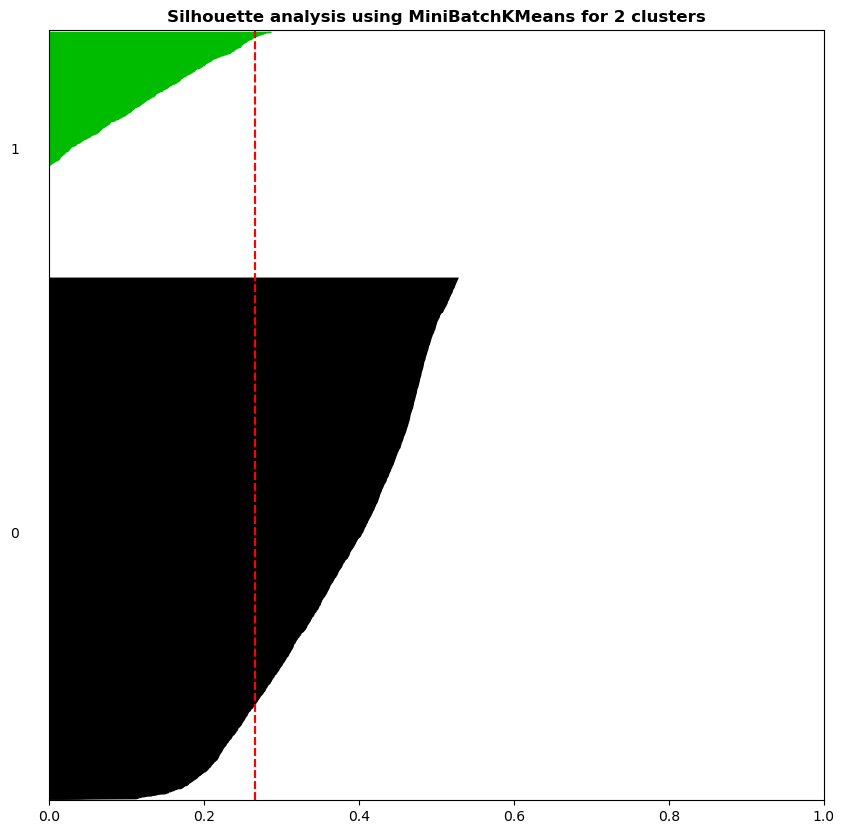

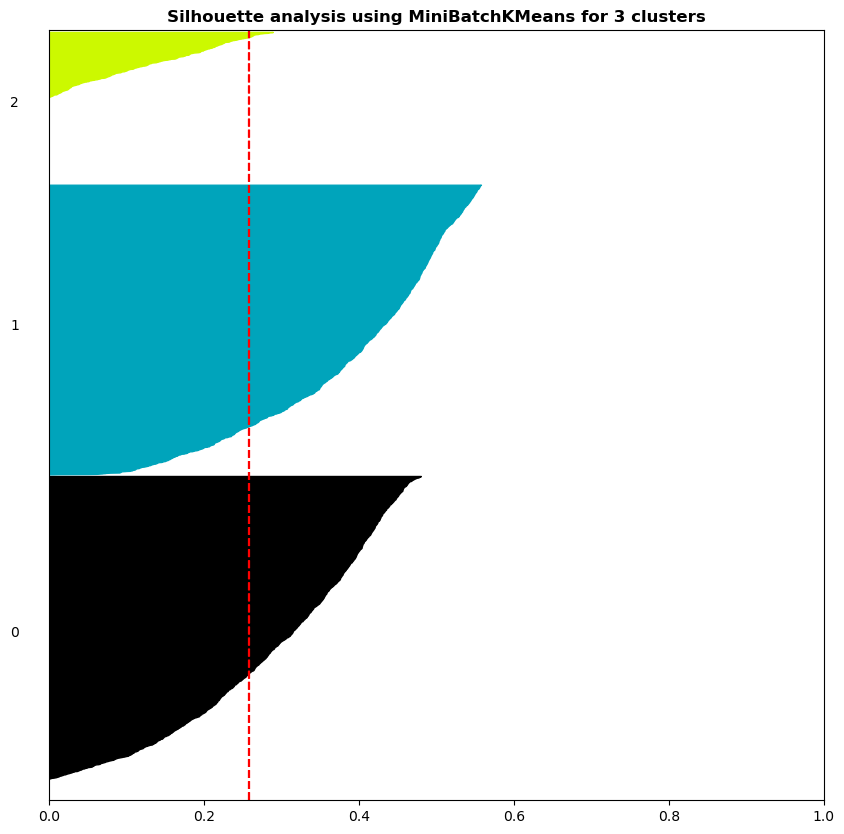

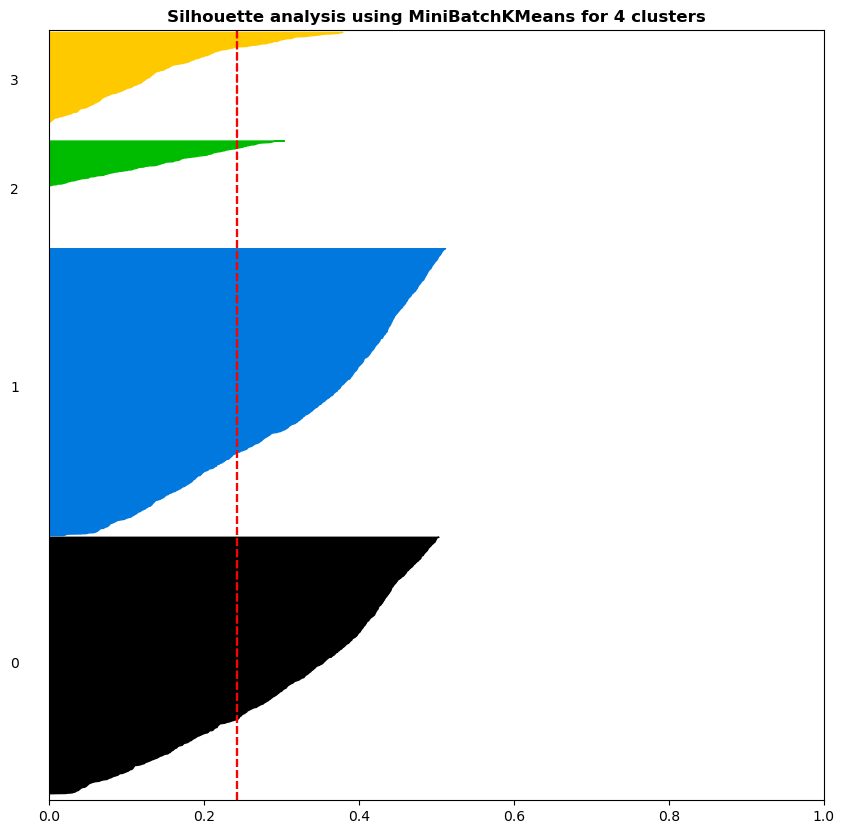

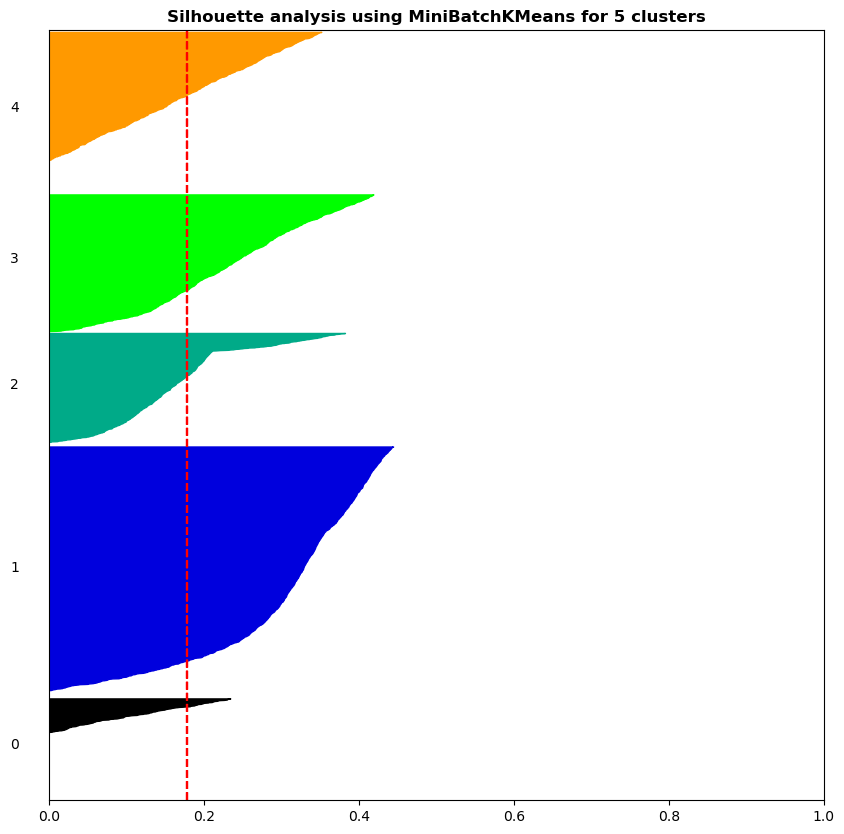

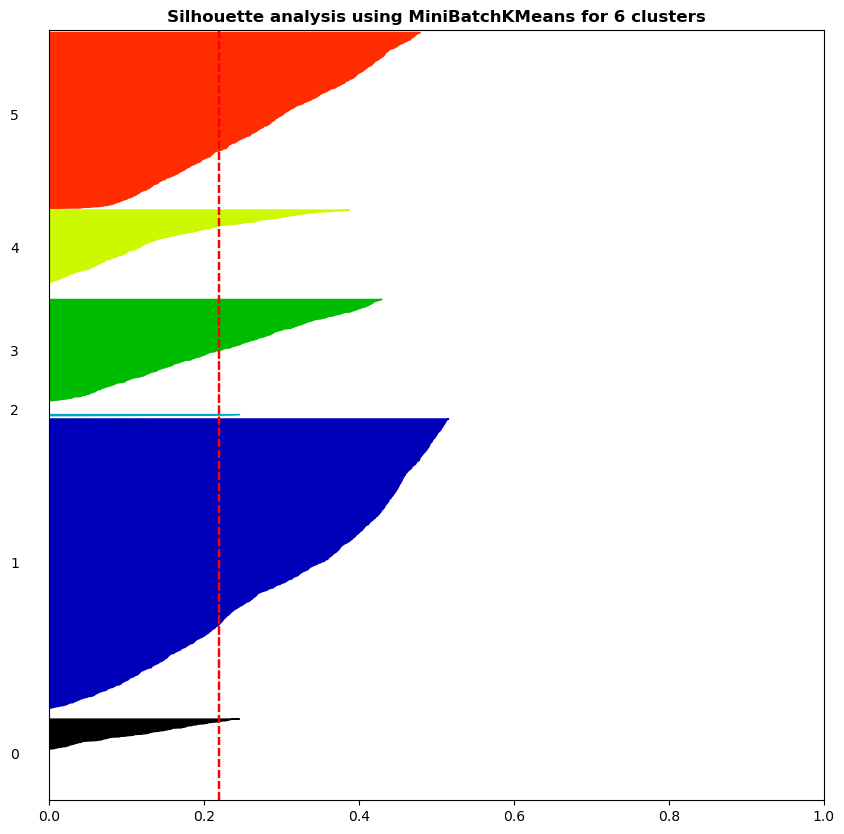

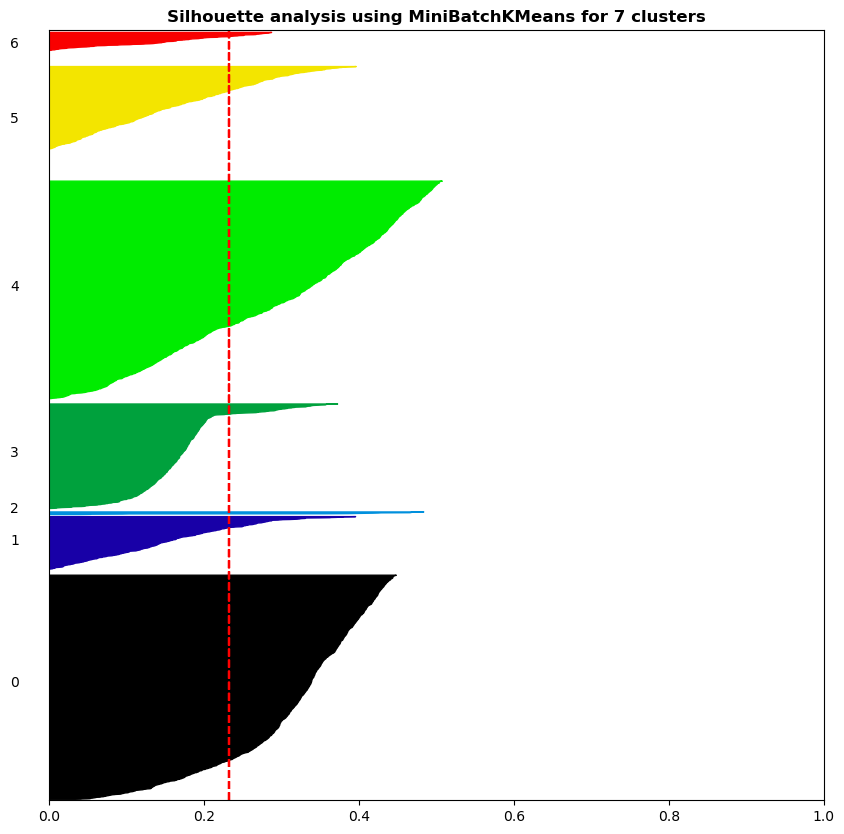

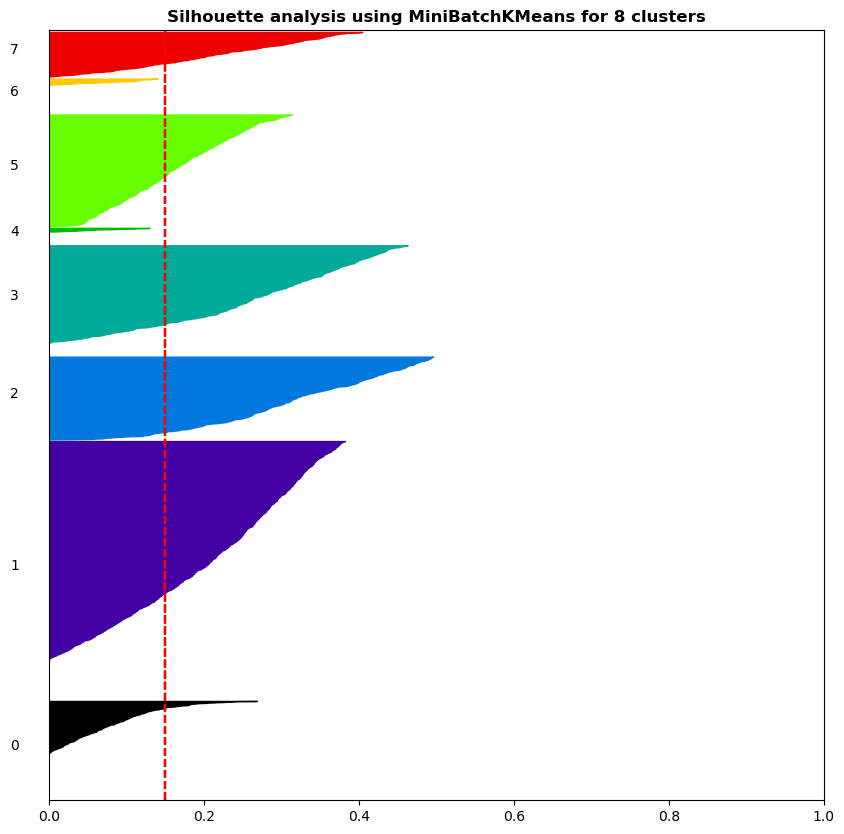

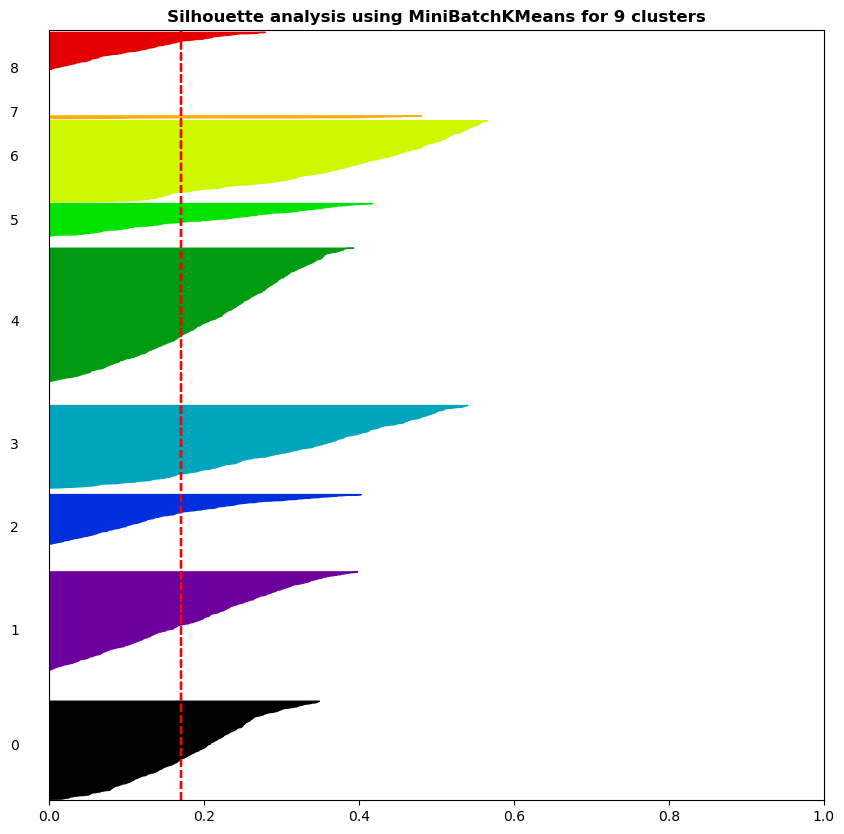

In [44]:
plt_silhouette(clusters, MiniBatchKMeans)

For 2 clusters,
 the average silhouette score is 0.24159161305116653
For 3 clusters,
 the average silhouette score is 0.2063886910676111
For 4 clusters,
 the average silhouette score is 0.09714277539614563
For 5 clusters,
 the average silhouette score is 0.07454402350693842
For 6 clusters,
 the average silhouette score is 0.10709299045061027
For 7 clusters,
 the average silhouette score is 0.0701036522185709
For 8 clusters,
 the average silhouette score is 0.06236903445947146
For 9 clusters,
 the average silhouette score is 0.09091448835750063


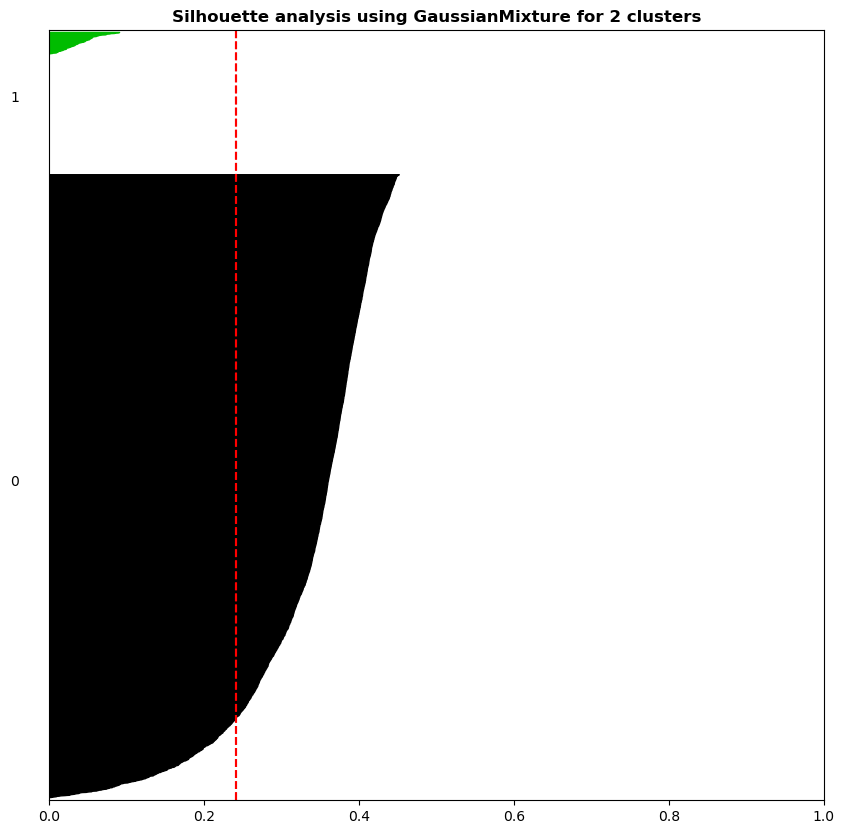

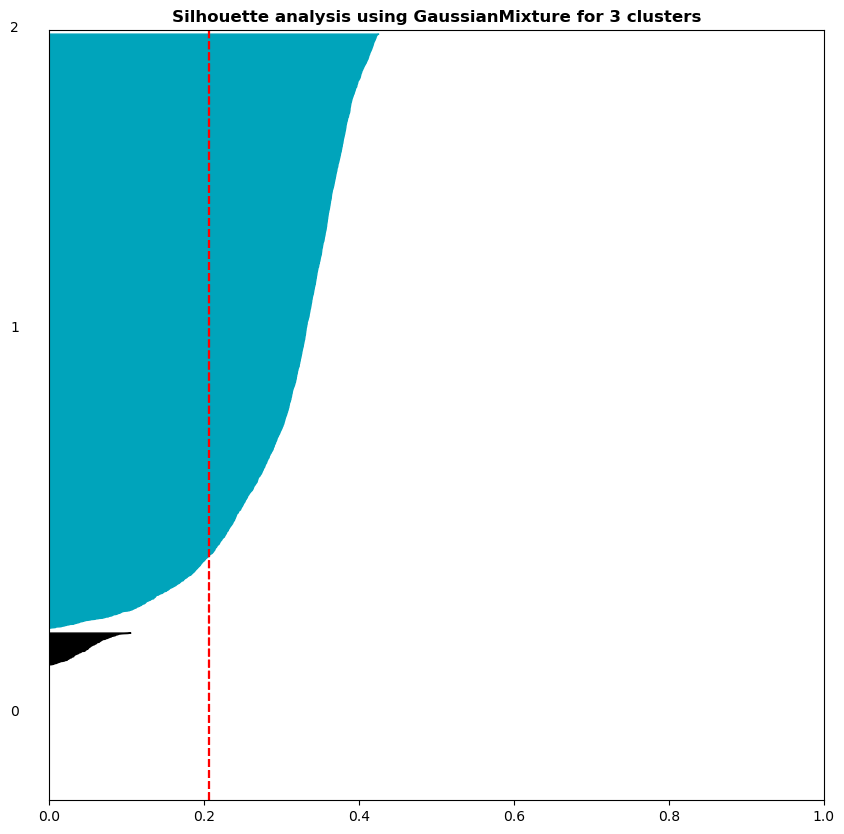

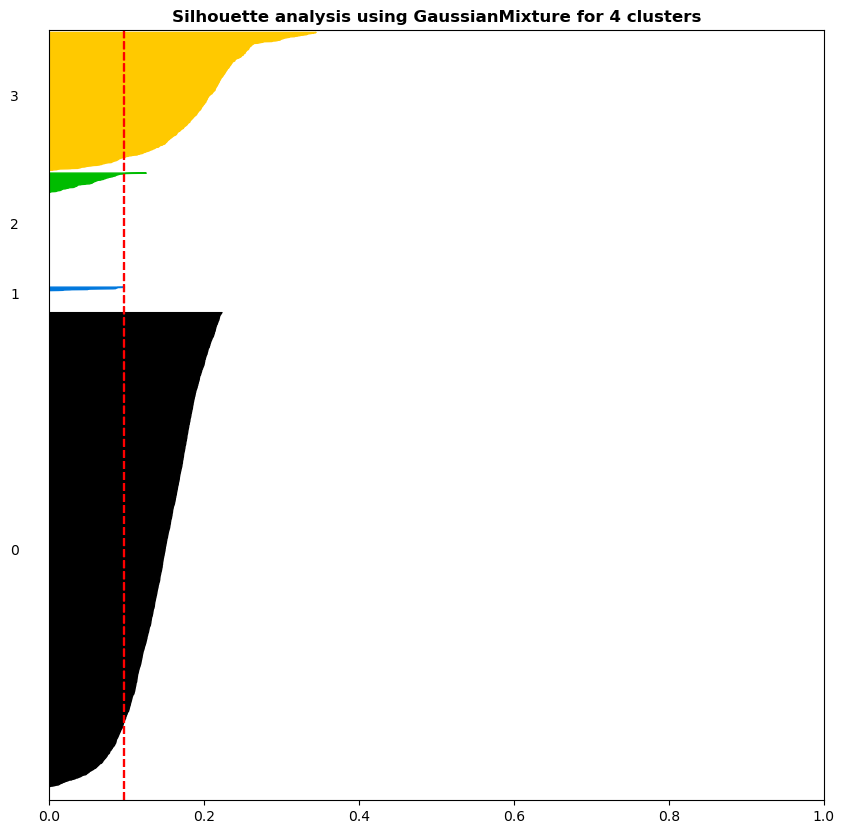

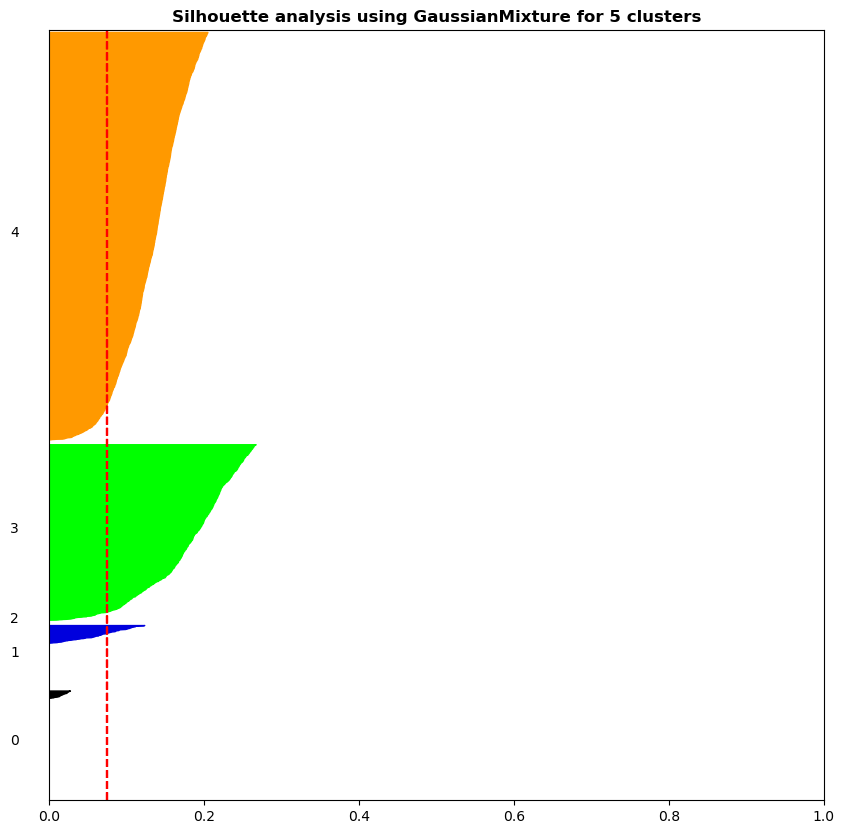

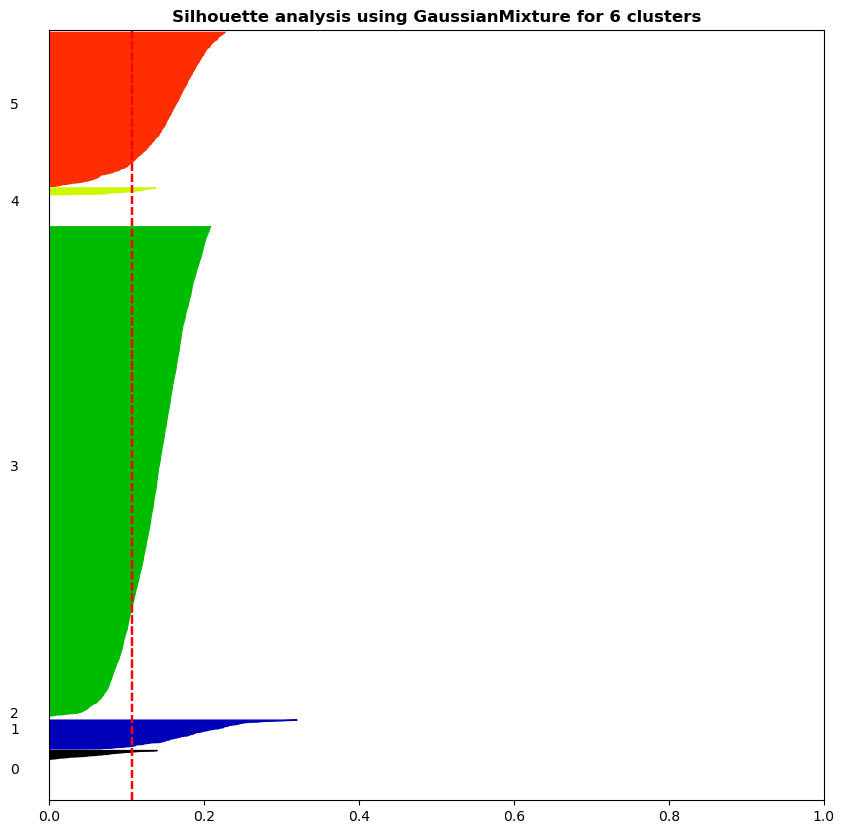

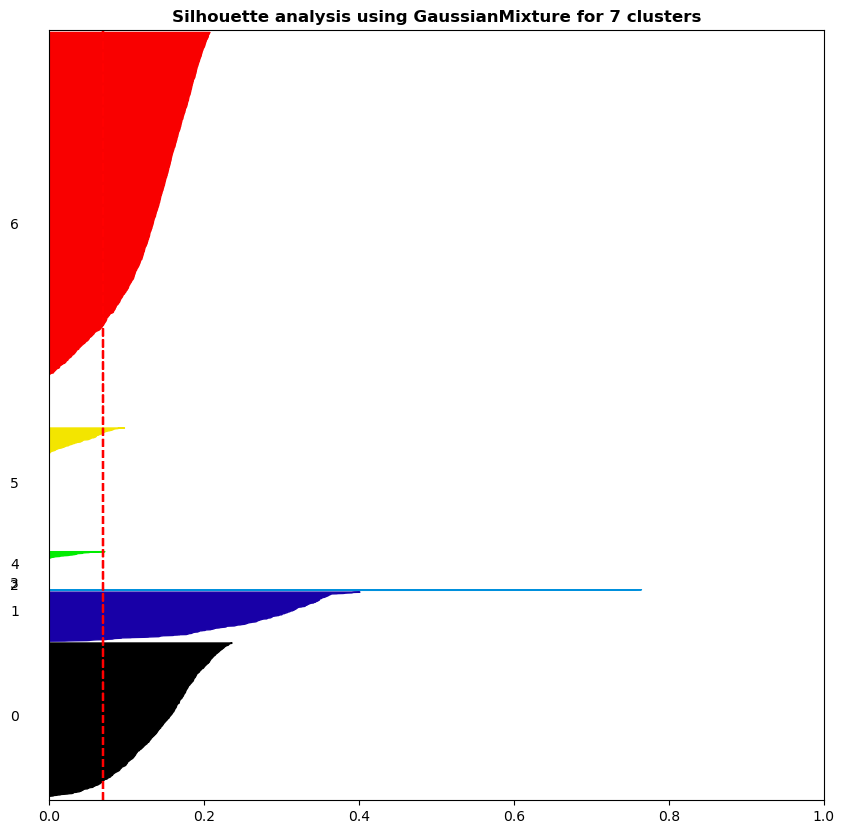

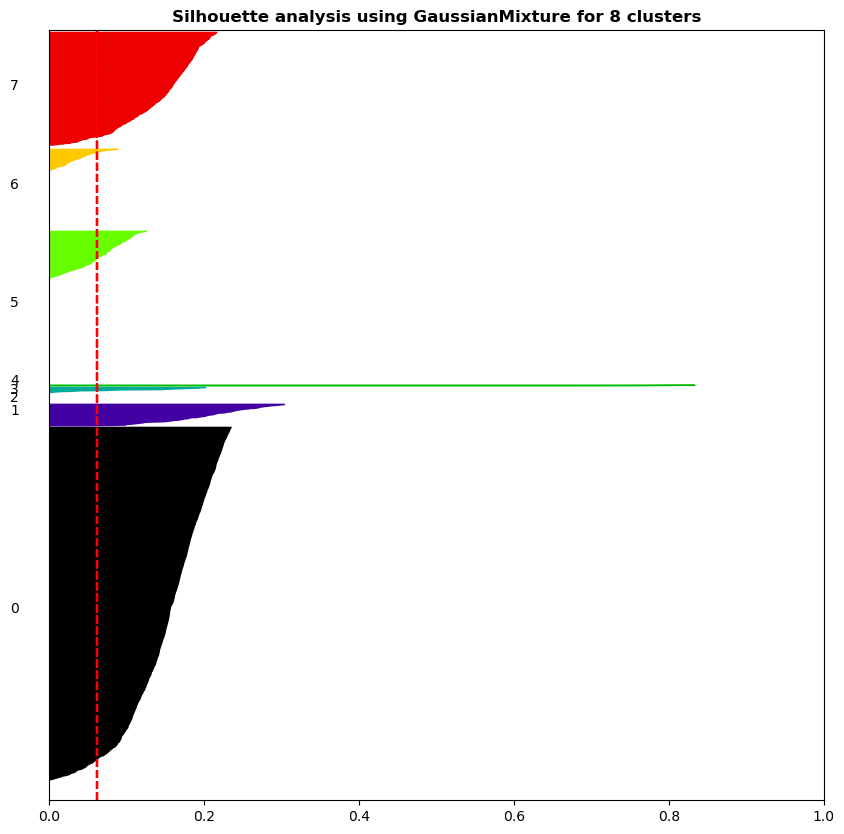

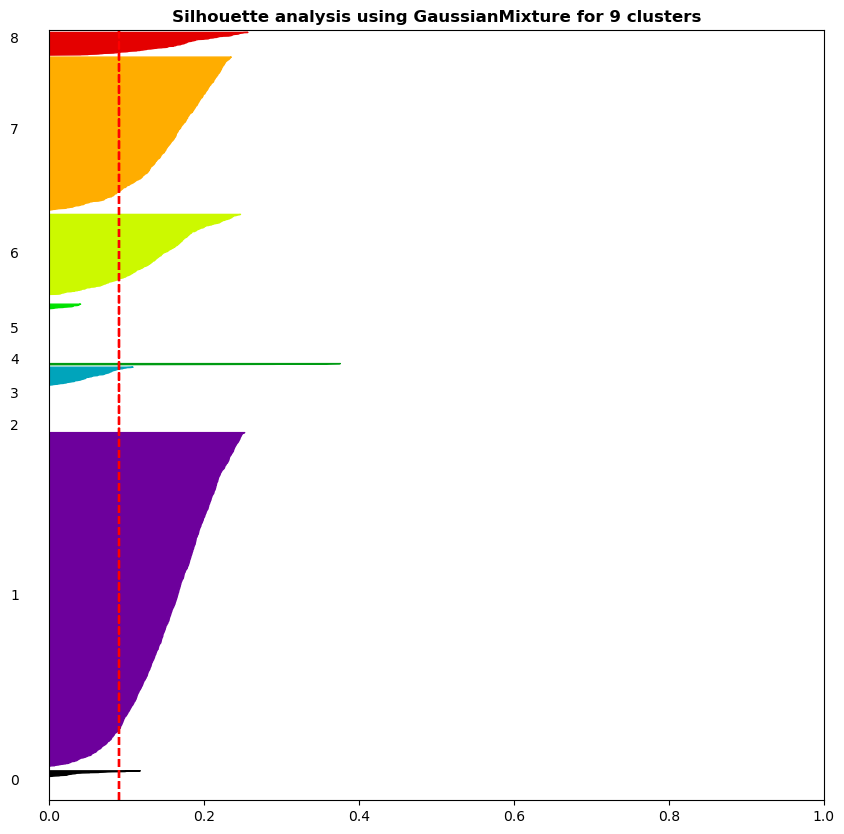

In [45]:
plt_silhouette(clusters, GaussianMixture)

With Silhouette score, you'd like  for the the groups to be of roughly equal sizes, and all of the clusters should have at least the average silhouette score. With regards to this, KMeans with two clusters seem to be the best, having a signifcantly higher silhouette score, and while one cluster is significantly smaller than the other, this is probably due to the large imbalance in the frequency of transactions. Let's see what happens when we exclude the frequency

For 2 clusters,
 the average silhouette score is 0.29444353964631376
For 3 clusters,
 the average silhouette score is 0.32402865427116273
For 4 clusters,
 the average silhouette score is 0.3307787181548288
For 5 clusters,
 the average silhouette score is 0.2943885255742913
For 6 clusters,
 the average silhouette score is 0.29614840012701105
For 7 clusters,
 the average silhouette score is 0.22363751243239846
For 8 clusters,
 the average silhouette score is 0.25937091761194936
For 9 clusters,
 the average silhouette score is 0.21600140076318178


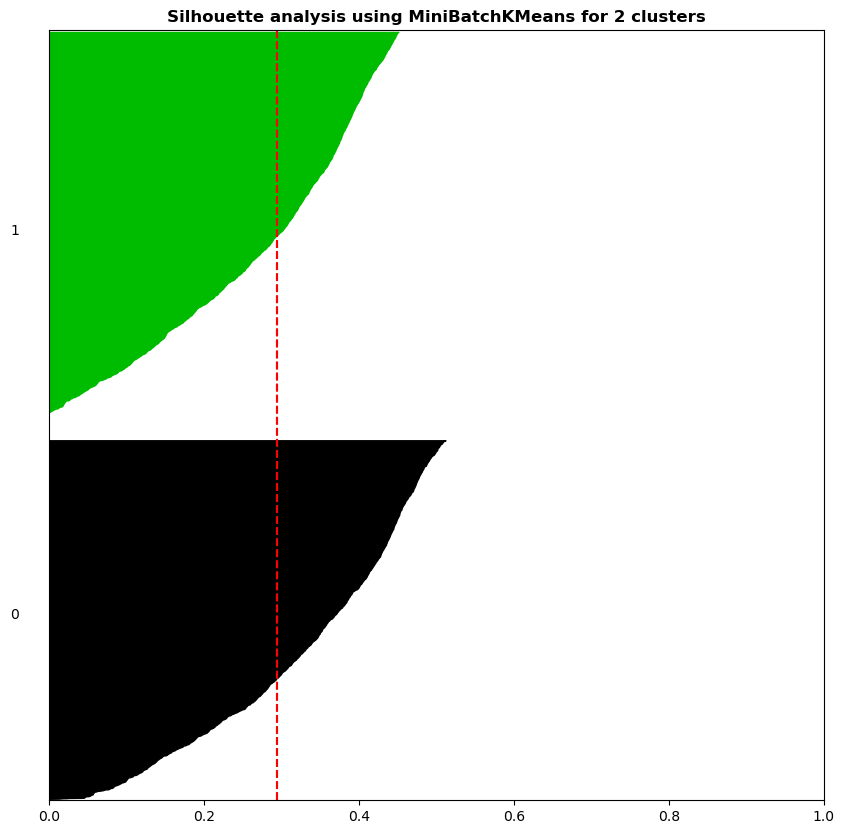

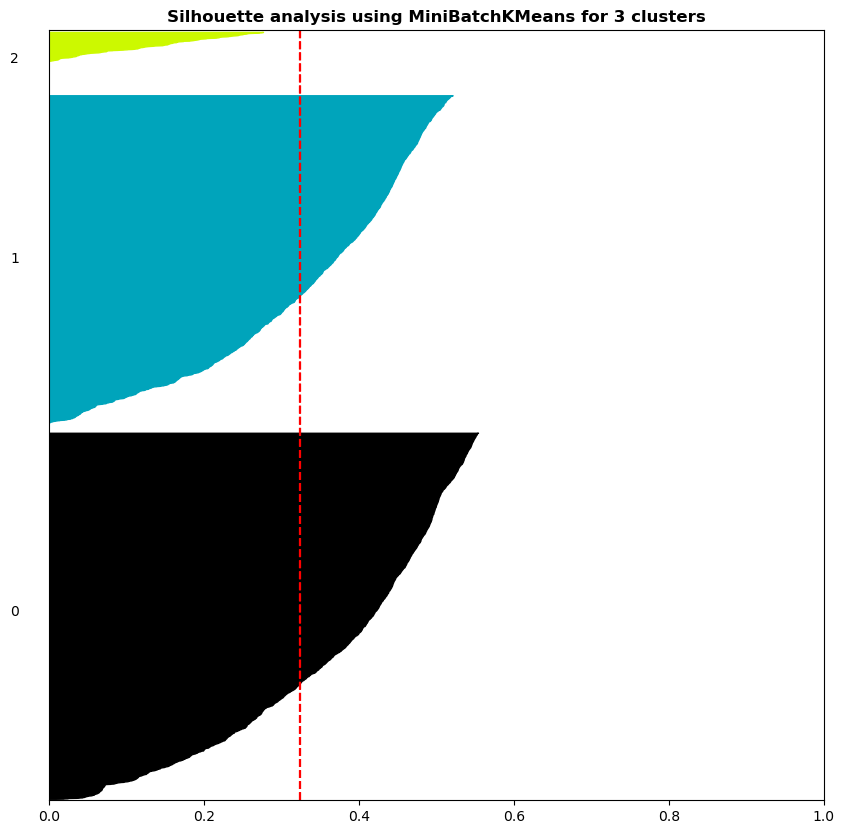

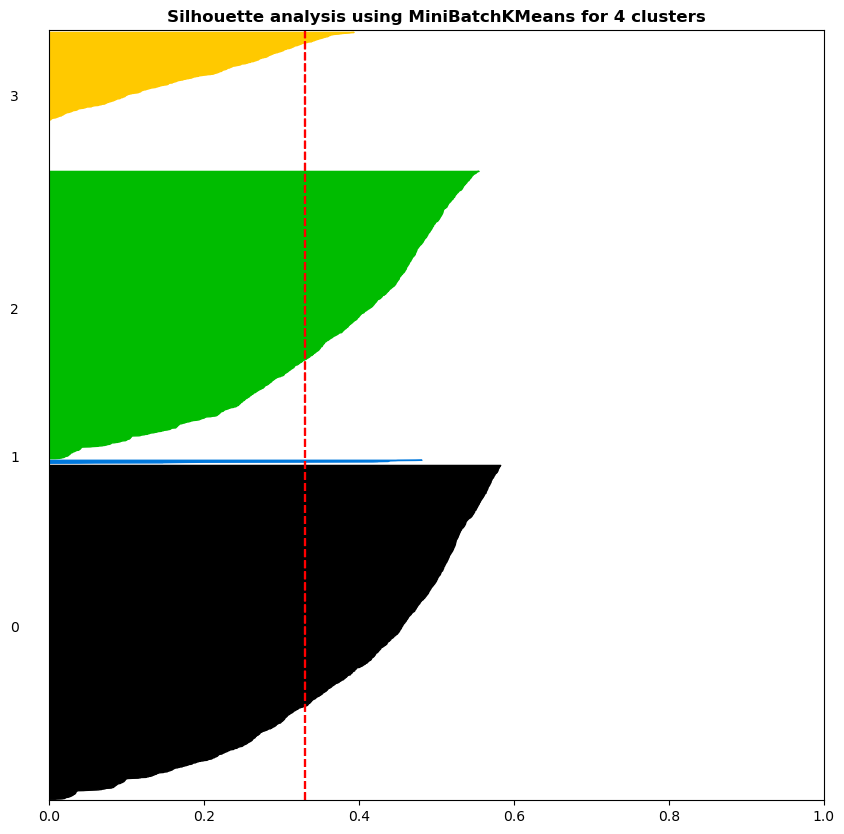

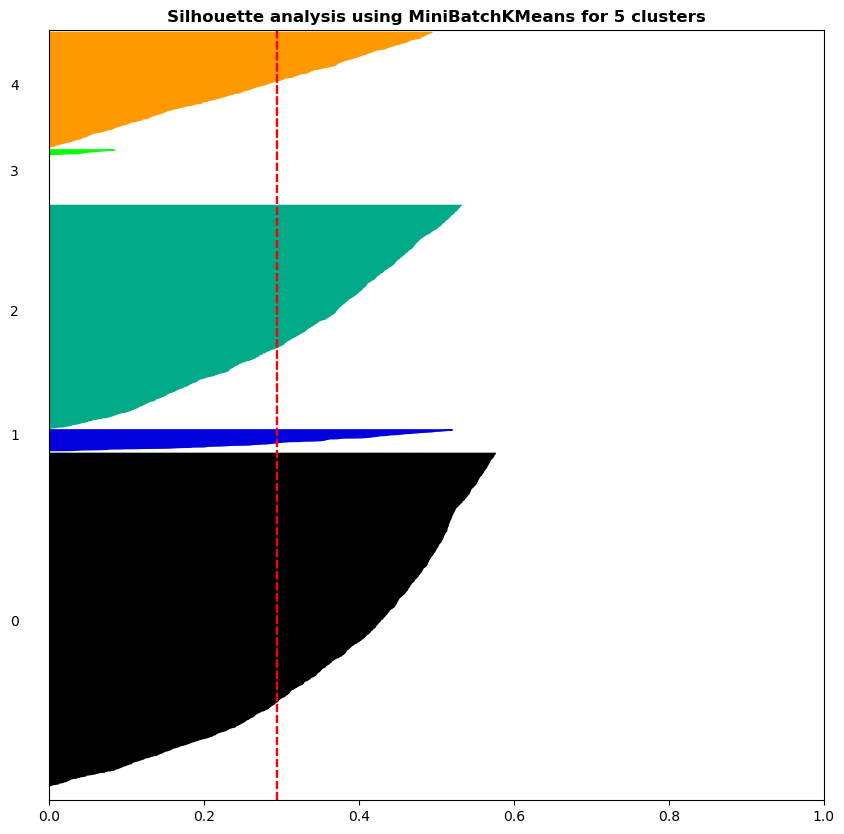

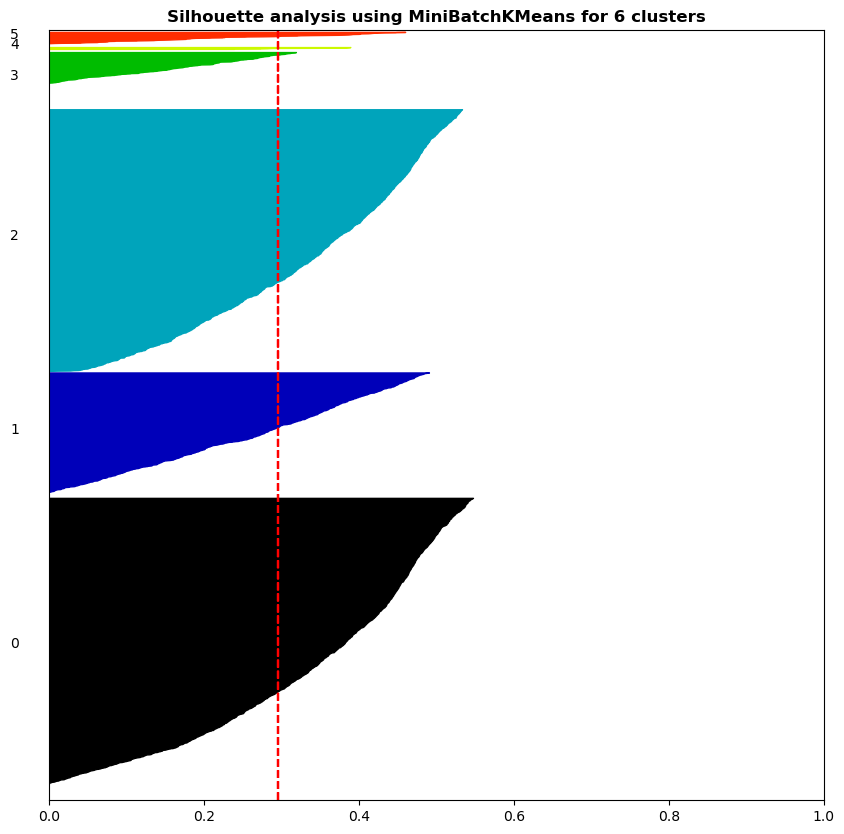

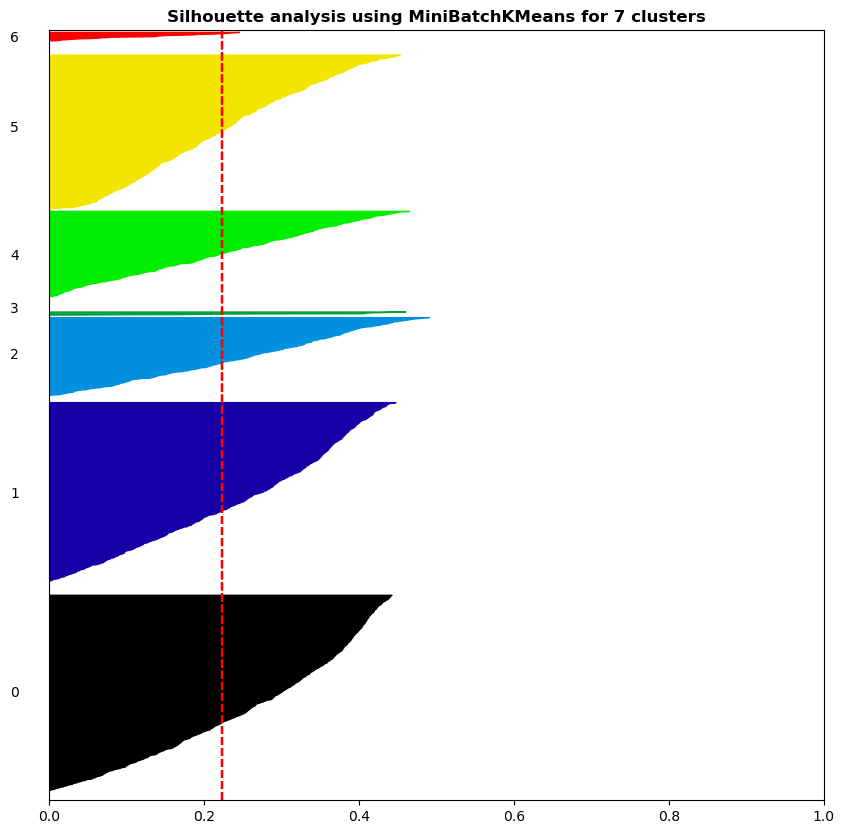

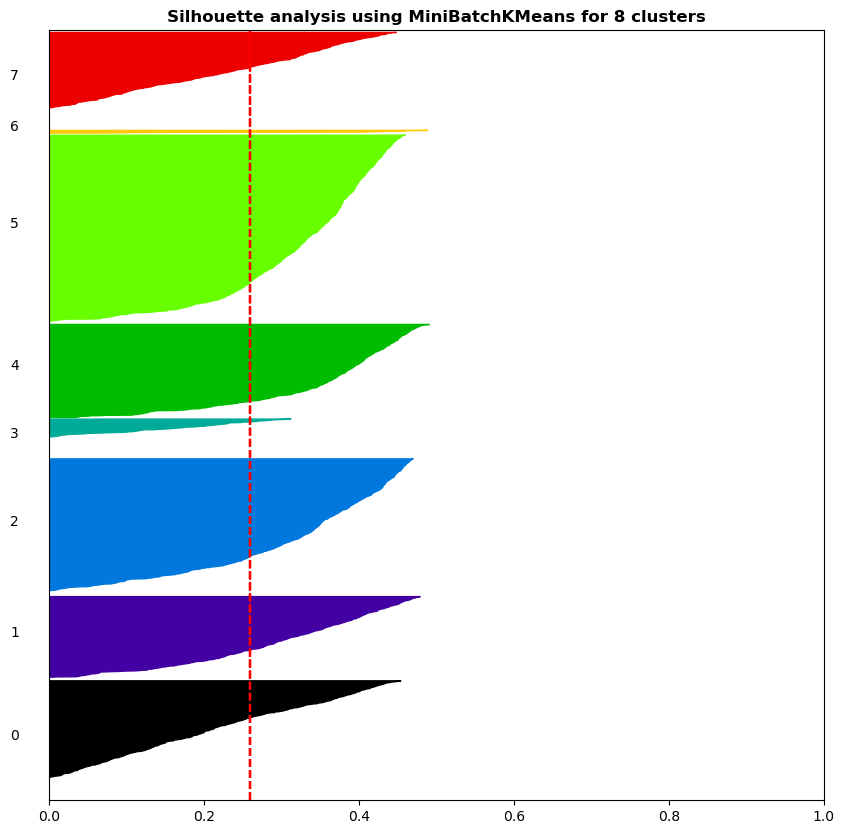

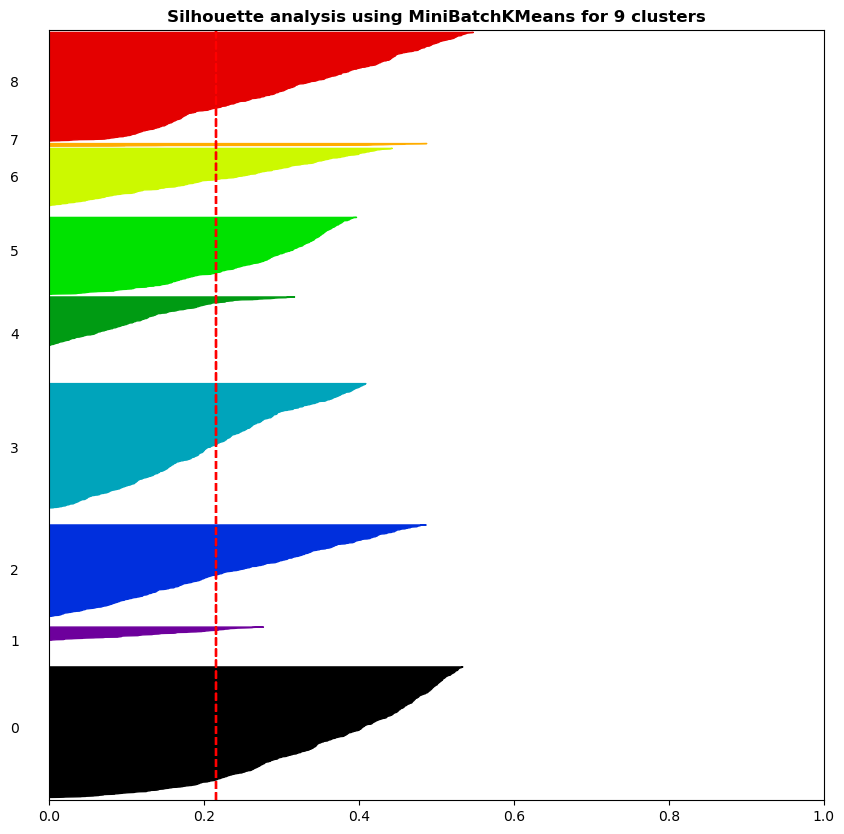

In [46]:
X = location_6.drop(columns = ['TransactionID_x', 'CustLocation', 'TransactionFrequency'])
df_cluster_X = df_cluster.drop(columns = ['TransactionID_x', 'CustLocation', 'TransactionFrequency'])
ct_fit = ct.fit(X)
X = ct_fit.transform(X)
df_cluster_X = ct_fit.transform(df_cluster)
plt_silhouette(clusters, MiniBatchKMeans)

In [ ]:
plt_silhouette(clusters, GaussianMixture)

For 2 clusters,
 the average silhouette score is 0.26621891397431785
For 3 clusters,
 the average silhouette score is 0.03348331707458992
For 4 clusters,
 the average silhouette score is 0.09775287599595969
For 5 clusters,
 the average silhouette score is 0.09776880403568328
For 6 clusters,
 the average silhouette score is 0.08560014888201241
For 7 clusters,
 the average silhouette score is 0.025151900295016315


Selecting Clusters is a little tough. Two clusters, if we include the transaction frequency could make sense since that should leave the clusters as people with only one transaction, and people with multiple transactions. KMF analysis showed that there is no practical difference between these groups, however (look at either recenvy vs total score. That leaves either three or four clusters while excluding the frequency. The issue with three clusters is that one of the clusters has a below average silhouette score, while with four clusters, we have one class that has significantly lower numbers. Let's see what both have to offer.

In [ ]:
import pickle 
km3 = MiniBatchKMeans(n_clusters = 7)
km4 = MiniBatchKMeans(n_clusters = 8)

km3_fit = km3.fit(X)
location_6['Seven_Clusters'] = km3_fit.predict(X)
km4_fit = km4.fit(X)
location_6['Eight_Clusters'] = km4_fit.predict(X)

location_6.head()

knnPickle = open('clustering_model', 'wb') 
      
# source, destination 
pickle.dump(km4, knnPickle)  

# close the file
knnPickle.close()
                
      
# load the model from disk
loaded_model = pickle.load(open('clustering_model', 'rb'))

df_cluster['Seven_Clusters'] = km3.predict(df_cluster_X)
df_cluster['Eight_Clusters'] = loaded_model.predict(df_cluster_X)

df_cluster.head()



In [ ]:
##location_9['CustGender'] = location_9['CustGender'].map(lambda x: 'F' if x == 1 else 'M')
location_6['TransactionFrequency'] = location_6['TransactionFrequency'].astype(int)
#df_cluster['TransactionFrequency'] = location_9['TransactionFrequency'].astype(int)
fig, axes = plt.subplots(6, 2, figsize = (20, 20))
axes = axes.flatten()

continuous_columns = location_6.drop(columns = ['TransactionID_x','CustLocation', 'Seven_Clusters',
                                                'Eight_Clusters', 'CustGender', 'TransactionFrequency']).columns

cat_columns = location_6[['CustGender', 'TransactionFrequency']]

for idx, c_name in enumerate(cat_columns):
    sns.countplot(x = c_name, hue = 'Seven_Clusters',  data = location_6, ax = axes[2 * idx])
    sns.countplot(x = c_name, hue = 'Eight_Clusters', data = location_6, ax = axes[2 * idx + 1])
    axes[2 * idx].set_title(f'{c_name} Seven Clusters')
    axes[2 * idx + 1].set_title(f'{c_name} Eight Clusters')

for idx, c_name in enumerate(continuous_columns):
    sns.scatterplot(y = 'Seven_Clusters', x = c_name,  data = location_6, ax = axes[2 * (idx + 2)])
    sns.scatterplot(y = 'Eight_Clusters', x = c_name, data = location_6, ax = axes[2 * (idx + 2) + 1])
    axes[2 * idx].set_title(f'{c_name} Seven Clusters')
    axes[2 * idx + 1].set_title(f'{c_name} Eight Clusters')
    
plt.tight_layout()

There's nothing really indicating what's different about the groups. For the four clusters, the gender ratio, and transaction frequency ratios look roughly the same across the clusters, ie the ratio of M : F in cluster 3 appears to be the same ratio as cluster 0. Cluster 0, 1, 3 have the same account balance, and average transaction amount, while cluster 2 has some values exceeding these values. Age is really the same, adn the only other major difference is the recency (DaysSinceTransaction), where cluster 3 has mostly low recencies (as in days, not score), cluster 0 has middling, cluster 1 has high recency, however cluster 2 is all over the place.

A somewhat similar story exists for the three cluster situation.

In [ ]:
cust_id

In [ ]:
df_clustering = pd.DataFrame()
df_clustering['CustomerID'] = cust_id
df_clustering['Cluster'] = df_cluster['Eight_Clusters']

In [ ]:
df_clustering.head()

In [ ]:
df_clustering.to_csv('Segmented_op.csv',index=False)